In [1]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [2]:
input_dir = os.path.join('..', 'input')
file_csv = [file for file in os.listdir(input_dir)\
            if file.endswith('.csv')]
print(file_csv)

['historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


In [70]:
pd.set_option('max_columns', None)

In [3]:
## Pandas@reduce dataframe memory
def reduce_mem_usage(props, fillna=False, fillval=None):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ", col)
            print("dtype before: ", props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(fillval,inplace=True)  
            
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < pow(2, 8)-1:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < pow(2, 16)-1:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < pow(2, 32)-1:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [4]:
trans_df = pd.read_csv(os.path.join(input_dir, 'historical_transactions.csv'))
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
trans_df, _ = reduce_mem_usage(trans_df, fillna=False, fillval=-999)
train_df, _ = reduce_mem_usage(train_df, fillna=False, fillval=-999)

Memory usage of properties dataframe is : 3109.5357055664062  MB
******************************
Column:  city_id
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  installments
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  merchant_category_id
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  month_lag
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  purchase_amount
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  category_2
dtype before:  float64
[*]skip category_2 cause of NA value
******************************
Column:  state_id
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  subsector_id
dtype before:  int64

In [5]:
trans_df = pd.merge(trans_df, train_df, on=['card_id'], how='left')

In [6]:
del train_df

In [7]:
trans_df = trans_df[trans_df['authorized_flag']=='Y'][['card_id', 'purchase_date', 'purchase_amount', 'first_active_month', 'month_lag', 'target']]
print('[*]trans_df : {}'.format(trans_df.shape))

[*]trans_df : (26595452, 6)


In [8]:
trans_df = trans_df[~trans_df.target.isnull()]

In [9]:
print('[*]trans_df : {}'.format(trans_df.shape))

[*]trans_df : (16468145, 6)


In [10]:
trans_df['purchase_year'] = trans_df['purchase_date'].apply(lambda x: x[0:4])
trans_df['purchase_month'] = trans_df['purchase_date'].apply(lambda x: x[5:7])

In [11]:
trans_df['purchase_year'] = trans_df['purchase_year'].astype(int)
trans_df['purchase_month'] = trans_df['purchase_month'].astype(int)
trans_df['month_lag'] = trans_df['month_lag'].astype(int)

In [12]:
trans_df.head(3)

,card_id,purchase_date,purchase_amount,first_active_month,month_lag,target,purchase_year,purchase_month
401,C_ID_5037ff576e,2017-08-14 15:46:08,1.189469,2017-01,-4,-2.352713,2017,8
402,C_ID_5037ff576e,2017-03-05 14:57:51,-0.640069,2017-01,-9,-2.352713,2017,3
403,C_ID_5037ff576e,2017-08-15 10:45:28,-0.652256,2017-01,-4,-2.352713,2017,8


In [13]:
trans_df['new_purchase_month'] = trans_df['purchase_month'] - trans_df['month_lag']
trans_df['new_purchase_year'] = trans_df['purchase_year']

In [14]:
over_month_idx = trans_df[trans_df['new_purchase_month']>12].index.values

In [15]:
trans_df.loc[over_month_idx,'new_purchase_month'] = trans_df.loc[over_month_idx,'new_purchase_month'] - 12
trans_df.loc[over_month_idx,'new_purchase_year'] = trans_df.loc[over_month_idx,'purchase_year'] + 1

In [16]:
print('unique count -> new_purchase_month : {}'.format(max(trans_df.groupby(['card_id']).new_purchase_month.nunique())))
print('unique count -> new_purchase_year : {}'.format(max(trans_df.groupby(['card_id']).new_purchase_year.nunique())))

unique count -> new_purchase_month : 1
unique count -> new_purchase_year : 1


In [17]:
trans_df['first_active_year'] = trans_df['first_active_month'].apply(lambda x: x[0:4])
trans_df['first_active_month'] = trans_df['first_active_month'].apply(lambda x: x[5:])

In [18]:
print('unique count -> first_active_year : {}'.format(max(trans_df.groupby(['card_id']).first_active_year.nunique())))
print('unique count -> first_active_month : {}'.format(max(trans_df.groupby(['card_id']).first_active_month.nunique())))

unique count -> first_active_year : 1
unique count -> first_active_month : 1


In [19]:
trans_df.head(3)

,card_id,purchase_date,purchase_amount,first_active_month,month_lag,target,purchase_year,purchase_month,new_purchase_month,new_purchase_year,first_active_year
401,C_ID_5037ff576e,2017-08-14 15:46:08,1.189469,01,-4,-2.352713,2017,8,12,2017,2017
402,C_ID_5037ff576e,2017-03-05 14:57:51,-0.640069,01,-9,-2.352713,2017,3,12,2017,2017
403,C_ID_5037ff576e,2017-08-15 10:45:28,-0.652256,01,-4,-2.352713,2017,8,12,2017,2017


In [96]:
month_lag_mean = trans_df.groupby(['card_id', 'month_lag']).purchase_amount.mean().unstack()

In [97]:
month_mean_col_name = 'lag_{}_mean'

In [98]:
month_lag_mean.columns = [month_mean_col_name.format(str(x)) for x in month_lag_mean.columns]

In [99]:
month_lag_mean.fillna(0, inplace=True)

In [100]:
month_lag_mean = pd.merge(month_lag_mean, trans_df[['card_id', 'target']], on=['card_id'], how='left')
month_lag_mean = month_lag_mean.drop_duplicates()

In [101]:
month_lag_mean.head(10)

,card_id,lag_-13_mean,lag_-12_mean,lag_-11_mean,lag_-10_mean,lag_-9_mean,lag_-8_mean,lag_-7_mean,lag_-6_mean,lag_-5_mean,lag_-4_mean,lag_-3_mean,lag_-2_mean,lag_-1_mean,lag_0_mean,target
0,C_ID_00007093c1,0.000000,-0.333604,-0.560815,-0.546012,-0.574854,-0.577617,-0.617820,-0.471708,-0.556233,-0.627612,-0.499872,-0.530359,-0.570987,-0.502207,0.134077
114,C_ID_0001506ef0,-0.708590,-0.691466,-0.693088,0.000000,-0.701828,-0.731430,0.017190,-0.108657,-0.168011,-0.290733,-0.513078,-0.607728,-0.453826,-0.155333,0.884295
176,C_ID_000183fdda,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.632501,-0.602618,-0.373307,-0.497646,-0.270757,-0.558534,-0.264433
313,C_ID_00027503e2,0.000000,0.000000,0.000000,0.000000,0.000000,-0.740897,-0.738801,-0.742058,-0.740211,-0.741667,-0.744038,-0.737141,-0.739492,-0.736389,0.812872
337,C_ID_0002c7c2c1,0.000000,0.000000,0.000000,0.000000,-0.593697,-0.656854,-0.637835,-0.683491,-0.618885,-0.649669,-0.668811,-0.666319,-0.667019,-0.677773,1.288514
395,C_ID_0003be3c83,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.587667,-0.672259,-0.631244,-0.601158,-0.678153,-0.678934,-0.691995,-0.083268
541,C_ID_00042d509c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.735187,-0.425806,-0.683421,-0.704191,-0.715683,-0.674071,-1.264398
559,C_ID_0004888ddd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.713420,-0.693968,-0.688575,-0.736464,-0.720942,-0.714751,-0.684059,0.512450
595,C_ID_0004b68c49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277735,-0.706223,0.000000,-0.693736,2.070529
600,C_ID_0004c2a5ab,-0.668702,-0.651534,-0.589265,-0.591271,-0.581491,-0.652853,-0.654735,-0.638076,-0.697399,-0.646756,-0.626428,-0.612791,-0.580464,-0.554563,-0.537806


In [118]:
rate_col_name = 'rate_{}_{}'

In [119]:
for month in range(0, -13, -1):
    before_col = month_mean_col_name.format(month)
    after_col = month_mean_col_name.format(month - 1)
    month_lag_mean[rate_col_name.format(month, month-1)] = month_lag_mean[after_col] / month_lag_mean[before_col]

In [120]:
month_lag_mean.head(3)

,card_id,lag_-13_mean,lag_-12_mean,lag_-11_mean,lag_-10_mean,lag_-9_mean,lag_-8_mean,lag_-7_mean,lag_-6_mean,lag_-5_mean,lag_-4_mean,lag_-3_mean,lag_-2_mean,lag_-1_mean,lag_0_mean,target,rate_0_-1,rate_-1_-2,rate_-2_-3,rate_-3_-4,rate_-4_-5,rate_-5_-6,rate_-6_-7,rate_-7_-8,rate_-8_-9,rate_-9_-10,rate_-10_-11,rate_-11_-12,rate_-12_-13,rate_mean
0,C_ID_00007093c1,0.00000,-0.333604,-0.560815,-0.546012,-0.574854,-0.577617,-0.61782,-0.471708,-0.556233,-0.627612,-0.499872,-0.530359,-0.570987,-0.502207,0.134077,1.136956,0.928847,0.942515,1.255546,0.886268,0.848041,1.309750,0.934928,0.995217,0.949826,1.027112,0.594855,-0.000000,0.984155
114,C_ID_0001506ef0,-0.70859,-0.691466,-0.693088,0.000000,-0.701828,-0.731430,0.01719,-0.108657,-0.168011,-0.290733,-0.513078,-0.607728,-0.453826,-0.155333,0.884295,2.921639,1.339120,0.844256,0.566645,0.577889,0.646722,-0.158208,-42.548931,0.959528,-0.000000,-inf,0.997659,1.024765,-2.735743
176,C_ID_000183fdda,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.632501,-0.602618,-0.373307,-0.497646,-0.270757,-0.558534,-0.264433,0.484763,1.837982,0.750145,1.614268,1.049589,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
rate_cols = [x for x in month_lag_mean.columns if 'rate' in x]

In [127]:
month_lag_mean['rate_mean'] = month_lag_mean[rate_cols].apply(lambda x: np.mean([rate for rate in x if -1<=rate<=1]), axis=1)

In [129]:
month_lag_mean['rate_std'] = month_lag_mean[rate_cols].apply(lambda x: np.std([rate for rate in x if -1<=rate<=1]), axis=1)

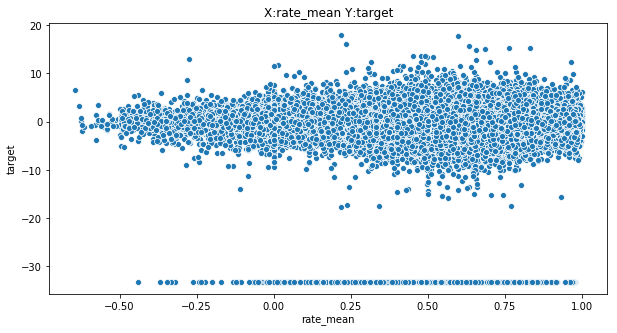

In [135]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_mean Y:target')
sns.scatterplot(x='rate_mean', y='target', data=month_lag_mean)

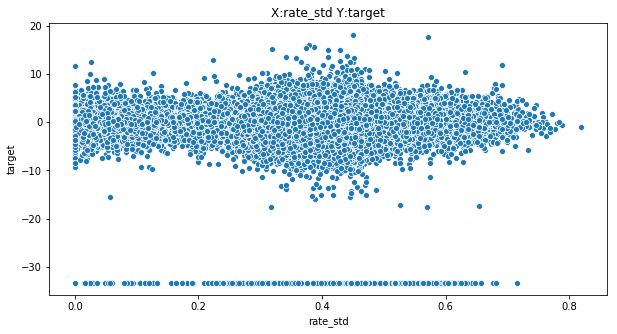

In [133]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_std Y:target')
sns.scatterplot(x='rate_std', y='target', data=month_lag_mean)